In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data_link = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
# file = requests.get(data_link)
# with open('names.txt', 'wb') as f:
#   f.write(file.content)

# words = open('names.txt', 'r').read().splitlines()

#alternative approach
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

--2024-06-14 18:33:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-06-14 18:33:10 (6.21 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# comment this part in the repo
word_count = len(words)
max_length = max(len(word) for word in words)
min_length = min(len(word) for word in words)

print(f"{word_count=} \n {max_length=} \n {min_length=}")

word_count=32033 
 max_length=15 
 min_length=2


## Bigram Implementation

In [4]:
# create a lookup table for strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [5]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182276, 8]) torch.Size([182276])
torch.Size([22940, 8]) torch.Size([22940])
torch.Size([22930, 8]) torch.Size([22930])


In [6]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# model architecture

n_embed = 24
n_hidden = 200
vocab_size = len(stoi.values())
num_layers = 1
output_size = vocab_size

# Model

class CustomLSTMModel:
  def __init__(self, n_embed, n_hidden, outptu_size, vocab_size, num_layers=1):
    self.hidden_size = n_hidden
    self.num_layers = num_layers
    self.vocab_size = vocab_size

    #Embedding layer
    self.embedding_weights = torch.randn(vocab_size, n_embed) #27, 24

    #LSTM Input Weights
    self.W_ih = torch.randn(n_hidden, n_embed)
    self.W_hh = torch.randn(n_hidden, n_hidden)
    self.b_ih = torch.randn(n_hidden)
    self.b_hh = torch.randn(n_hidden)

    #LSTM Output Weights
    self.W_oh = torch.randn(n_hidden, n_embed)
    self.W_oo = torch.randn(n_hidden, n_hidden)
    self.b_oh = torch.randn(n_hidden)
    self.b_oo = torch.randn(n_hidden)

    #LSTM forget Weights
    self.W_fh = torch.randn(n_hidden, n_embed)
    self.W_ff = torch.randn(n_hidden, n_hidden)
    self.b_fh = torch.randn(n_hidden)
    self.b_ff = torch.randn(n_hidden)

    #LSTM Cell Weights
    self.W_ch = torch.randn(n_hidden, n_embed)
    self.W_cc = torch.randn(n_hidden, n_hidden)
    self.b_ch = torch.randn(n_hidden)
    self.b_cc = torch.randn(n_hidden)

    #Linear Layer Weights
    self.linear_weights = torch.randn(output_size, n_hidden)
    self.linear_bias = torch.randn(output_size)

  def init_hidden(self, batch_size):
    h0 = torch.zeros(batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(batch_size, self.hidden_size).to(device)
    return h0, c0

  def __call__(self, x):
    batch_size, seq_len = x.size()
    h, c = self.init_hidden(batch_size)

    # Embedding lookup
    embeds = self.embedding_weights[x]

    #Iterate over sequence
    for t in range(seq_len):
      xt = embeds[:, t, :]

      # Input Gate
      i_t = torch.sigmoid(xt @ self.W_ih.T + self.b_ih + h @ self.W_hh.T + self.b_hh)

      # Forget Gate
      f_t = torch.sigmoid(xt @ self.W_fh.T + self.b_fh + h @ self.W_ff.T + self.b_ff)

      # Output Gate
      o_t = torch.sigmoid(xt @ self.W_oh.T + self.b_oh + h @ self.W_oo.T + self.b_oo)

      # Cell Gate
      g_t = torch.tanh(xt @ self.W_ch.T + self.b_ch + h @ self.W_cc.T + self.b_cc)

      # Cell State
      c = f_t * c + i_t * g_t

      # Hidden State
      h = o_t * torch.tanh(c)

      # Linear Layer
      out = h @ self.linear_weights.T + self.linear_bias

    return out
  def parameters(self):
    params = [
        self.embedding_weights,
        self.W_ih, self.W_hh, self.b_ih, self.b_hh,
        self.W_fh, self.W_ff, self.b_fh, self.b_ff,
        self.W_ch, self.W_cc, self.b_ch, self.b_cc,
        self.W_oh, self.W_oo, self.b_oh, self.b_oo,
        self.linear_weights, self.linear_bias,
    ]
    return params

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters())   #this can be used instead of nelement()

  def zero_grad(self):
    for p in self.parameters():
      p.grad = None

  def requires_grad(self, flag):
    for p in self.parameters():
      p.requires_grad = flag

  def to(self, device):
        # Move all parameters to the specified device
        self.embedding_weights = self.embedding_weights.to(device)
        self.W_ih = self.W_ih.to(device)
        self.W_hh = self.W_hh.to(device)
        self.b_ih = self.b_ih.to(device)
        self.b_hh = self.b_hh.to(device)

        self.W_fh = self.W_fh.to(device)
        self.W_ff = self.W_ff.to(device)
        self.b_fh = self.b_fh.to(device)
        self.b_ff = self.b_ff.to(device)

        self.W_oh = self.W_oh.to(device)
        self.W_oo = self.W_oo.to(device)
        self.b_oh = self.b_oh.to(device)
        self.b_oo = self.b_oo.to(device)

        self.W_ch = self.W_ch.to(device)
        self.W_cc = self.W_cc.to(device)
        self.b_ch = self.b_ch.to(device)
        self.b_cc = self.b_cc.to(device)

        self.linear_weights = self.linear_weights.to(device)
        self.linear_bias = self.linear_bias.to(device)



model = CustomLSTMModel(n_embed, n_hidden, output_size, vocab_size, num_layers)
model.to(device)


with torch.no_grad():
  model.linear_weights *= 0.1     #nn.Module layers have an attribute weight. but raw tensors don't

print(model.count_parameters())

model.requires_grad(True)





186875


In [16]:
# actual training process
max_steps = 1000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  Xb = Xb.to(device)
  Yb = Yb.to(device)

  # pass xb through the model
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backprop
  for p in model.parameters():
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in model.parameters():
    p.data += -lr * p.grad
  lossi.append(loss.log10().item())
  if i % 100 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/   1000: 2.0928
    100/   1000: 1.9321
    200/   1000: 2.1935
    300/   1000: 2.1540
    400/   1000: 2.1037
    500/   1000: 1.9821
    600/   1000: 2.2202
    700/   1000: 1.8444
    800/   1000: 2.0765
    900/   1000: 2.0102


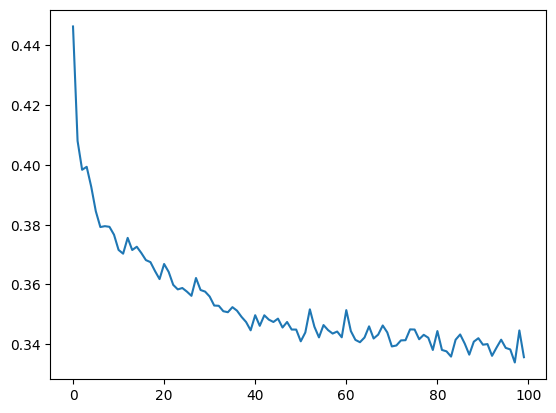

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 300).mean(1))

In [17]:
# evaluation on entire dataset

@torch.no_grad()   # for faster operation
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  x = x.to(device)
  y = y.to(device)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.2185
val loss: 2.2366


In [18]:
# sampling from the model
g = torch.Generator().manual_seed(1234543)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # remember to preserve first dim of context
    context_tensor = torch.tensor([context], device=device)
    logits = model(context_tensor)
    probs = F.softmax(logits, dim=1)


    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))



pailallea.
mily.
livoe.
lenlyn.
simeli.
kailee.
matthle.
lertsi.
monero.
olpea.
rixban.
ayso.
shayree.
aysovi.
layar.
modd.
tayla.
shayma.
molane.
zeater.
